In [460]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM,Dropout
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [506]:
df = web.DataReader('TSLA', data_source='yahoo', start='2013-01-01', end='2019-12-17') 
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2013-01-02,7.090000,6.942000,7.000000,7.072000,5974000,7.072000
2013-01-03,7.090000,6.950000,7.036000,6.954000,3710000,6.954000
2013-01-04,6.960000,6.784000,6.960000,6.880000,3370000,6.880000
2013-01-07,6.960000,6.780000,6.960000,6.868000,2210000,6.868000
2013-01-08,6.900000,6.622000,6.900000,6.736000,6420000,6.736000
...,...,...,...,...,...,...
2019-12-11,71.438004,70.218002,70.375999,70.540001,34489000,70.540001
2019-12-12,72.547997,70.646004,70.984001,71.935997,38819500,71.935997
2019-12-13,73.042000,70.928001,72.209999,71.678001,32854500,71.678001


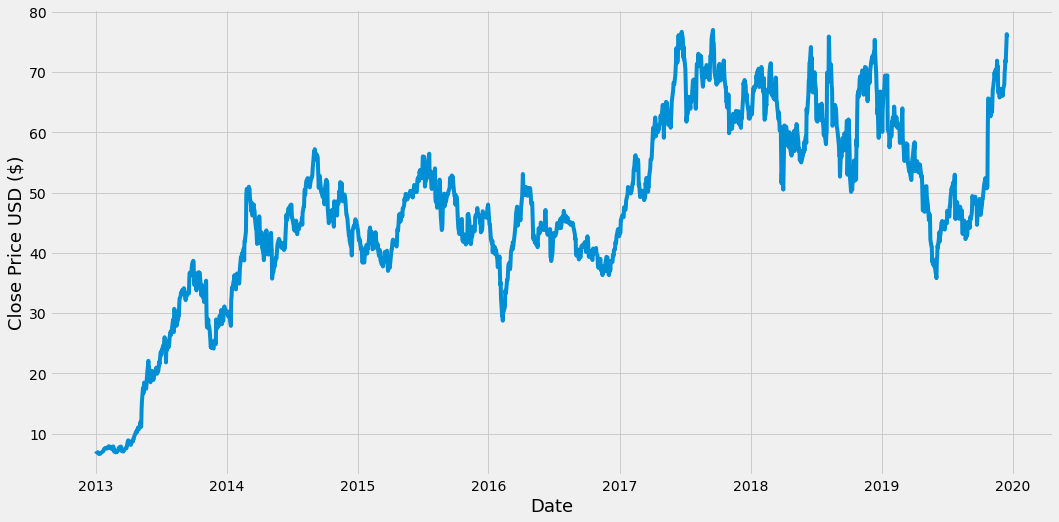

In [507]:
plt.figure(figsize=(16,8))
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

In [508]:
data = df.filter(['Close'])
dataset = data.values
training_data_len = math.ceil( len(dataset) *.8) 

In [509]:
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [510]:
train_data = scaled_data[0:training_data_len  , : ]
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [511]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [512]:
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [513]:
def build_model(shape):
  model =Sequential(
      [
       LSTM(units=50, return_sequences=True,input_shape=(shape[1],1)),
       Dropout(0.2),
       LSTM(units=50, return_sequences=True),
       Dropout(0.2),
       LSTM(units=50, return_sequences=False),
       Dropout(0.2),
       Dense(units=25),
       Dense(units=1)
      ]
  )
  return model
model = build_model(x_train.shape)

In [526]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=2)

Epoch 1/2
1343/1343 [==============================] - 13s 9ms/step - loss: 0.0034
Epoch 2/2
1343/1343 [==============================] - 12s 9ms/step - loss: 0.0027


In [527]:
test_data = scaled_data[training_data_len - 60: , : ]
x_test = []
y_test =  dataset[training_data_len : , : ]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [528]:
x_test = np.array(x_test)

In [529]:
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [530]:
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)

In [531]:
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

2.998569085431484

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


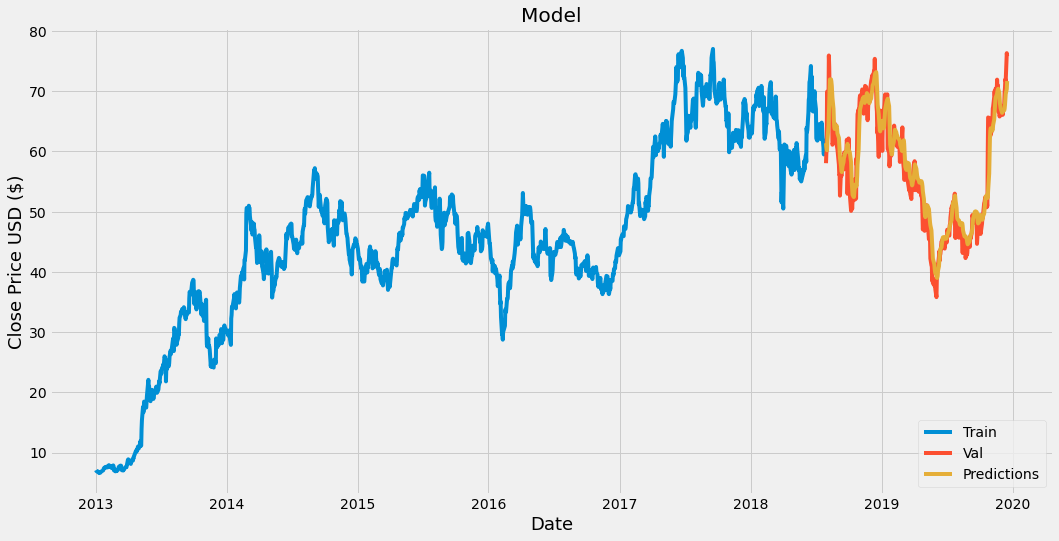

In [532]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()